In [1]:

import jax
import os



os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
print(jax.local_devices())



import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

import math

from jax import grad

from scipy import integrate

[cuda(id=0)]


In [2]:
# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1] # Removing the last spurious element 

vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
@jit
def dst_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    return vmap_dst(vmap_dst(A).T).T


vmap_dst_2d = jit(vmap(dst_2d, in_axes = 0))#jit(vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1))
@jit
def double_dst_2d(A):
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes
    A = jnp.transpose(A, (2, 3, 0, 1))
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes (going back to the original order)
    A = jnp.transpose(A, (2, 3, 0,1))
    return A

# Defining the second order elliptic operators 
def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
    r =(x_1 - y_1) ** 2 + (x_2 - y_2) ** 2
    return jnp.exp(-r/length_scale)

In [3]:
matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

# Elliptic PDE with parameters

In [4]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


We will consider 


We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\Delta u + b(x,y)u&= \xi \\
u &= 0
\end{aligned}

We will consider a manufactured solution

\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}

Then 

$$
\xi =  \sum_{k=1}^\infty\sum_{l=1}^\infty u_{kl}(l^2 + k^2)^{-\alpha -\delta}(\pi^2(l^2 + k^2) + b(x,y))\sin(\pi k x) \sin(\pi l y) )


In [5]:
#plt.style.use('default')
plt.style.use('plot_style-Examples_3d.txt')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [6]:
def evaluate_function_sine_2d(x, y, k,l ,c):
    values = c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    values = jnp.where(k==0, c*jnp.outer(jnp.ones_like(x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y)), values)
    values = jnp.where(l==0, c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.ones_like(y)), values)
    return values

In [7]:
def evaluate_basis_sine_2d(x,y,c):
    # The frequency starts at 0
    f_1 = jnp.arange(0, c.shape[0])
    f_2 = jnp.arange(0, c.shape[0])
    return jnp.sum(jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,0,None, 0), out_axes= -1), in_axes= (None, None, None, 0, 1),out_axes= -1))(x, y,f_1, f_2, c), axis = (2,3))#jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,None,0, 1)), in_axes= (None, None, 0, None, 0)))(x, y,f_1, f_2, c)#vmap(evaluate_function_sine_2d, in_axes=(None,None,0,0, 0))(x, y,f_1, f_2, c)


def evaluate_function_sine_2d_iterative(x,y,c):
    values = jnp.zeros_like(jnp.outer(x, y))
    for k in range(c.shape[0]):
        for l in range(c.shape[1]):
            values += c[k,l]*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    return values

In [8]:
key = random.PRNGKey(647023)
#key = random.PRNGKey(311)

n_coef = 2**7
print("Number of coefficients: ", n_coef)

nu = 1e-3
#b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**2))+ 1.5)
#b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**2))+ 1.5)
b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**4)) + x**2 + jnp.exp(-y**2)+ 1.5)
vmap_b = jit(vmap(vmap(b, in_axes = (None, 0)), in_axes = (0, None)))


x_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
y_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
X, Y = jnp.meshgrid(x_finest, y_finest)
# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x_finest, y_finest, indexing='ij')
interior_finest = jnp.stack((A, B), axis=-1).reshape(-1, 2)



frequencies = jnp.arange(0, n_coef)

delta = .15
alpha = 1.0
random_draw =  random.normal(key, shape= (n_coef,n_coef))
decay = (jnp.arange(0,n_coef)[None]**2 + jnp.arange(0,n_coef)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_u= coef_u.at[:,0].set(0)
coef_u= coef_u.at[0,:].set(0)
coef_laplacian =coef_u*((nu*jnp.pi**2*decay))


Number of coefficients:  128


In [9]:
u_values = evaluate_basis_sine_2d(x_finest,y_finest, coef_u)
f_values =evaluate_basis_sine_2d(x_finest,y_finest, coef_laplacian) + vmap_b(x_finest, y_finest)*u_values

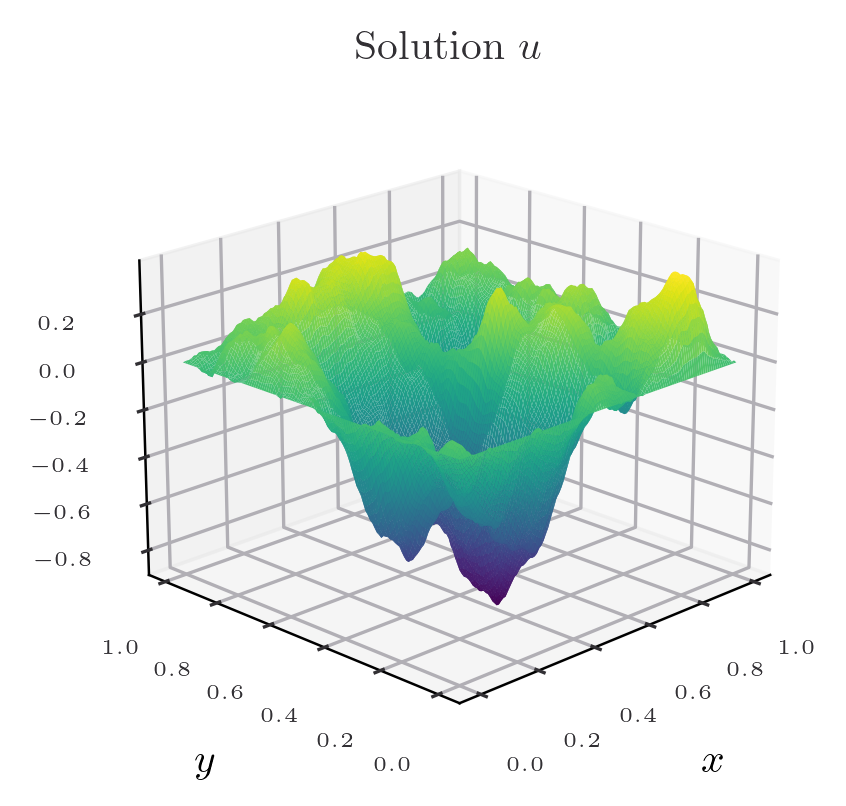

In [10]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

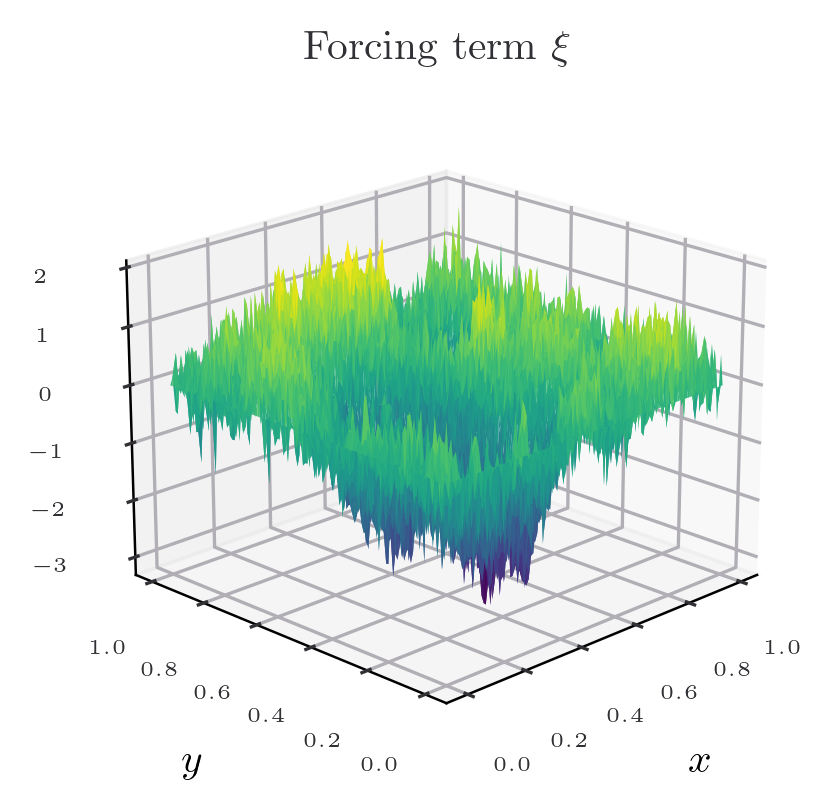

In [11]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [46]:
# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag)[:-1] # Removing the last spurious element 

vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
@jit
def dst_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    return vmap_dst(vmap_dst(A).T).T

In [47]:
u_trans = dst_2d(u_values)
f_trans = dst_2d(f_values)
coef_f = f_trans
print(jnp.mean(jnp.abs(u_trans- coef_u)))

4.347465704357499


In [48]:
a_test = u_values[50]
a_test[0], a_test[-1]

(Array(0., dtype=float64), Array(-0.00662548, dtype=float64))

In [49]:
discrete_sine_transform(discrete_sine_transform(a_test))*2/n

Array([ 0.00000000e+00, -1.61346075e-01, -4.07724328e-01, -6.00633803e-01,
       -7.97434560e-01, -1.00034119e+00, -1.17955909e+00, -1.39440597e+00,
       -1.64167052e+00, -1.84490734e+00, -1.98356428e+00, -2.04449225e+00,
       -2.05663706e+00, -2.07974227e+00, -2.12503191e+00, -2.13152663e+00,
       -2.09899571e+00, -2.07886968e+00, -2.06198565e+00, -2.01814786e+00,
       -1.95182983e+00, -1.89020424e+00, -1.85777354e+00, -1.81803671e+00,
       -1.74451256e+00, -1.63405572e+00, -1.50281785e+00, -1.42080033e+00,
       -1.39431050e+00, -1.38098479e+00, -1.36152823e+00, -1.36377101e+00,
       -1.39525850e+00, -1.41499382e+00, -1.43865511e+00, -1.47096104e+00,
       -1.49461128e+00, -1.54004955e+00, -1.61336485e+00, -1.71491676e+00,
       -1.84189673e+00, -1.95904995e+00, -2.04077187e+00, -2.07514620e+00,
       -2.08225290e+00, -2.07797801e+00, -2.03547723e+00, -1.97767550e+00,
       -1.92779169e+00, -1.85121986e+00, -1.73248242e+00, -1.58316710e+00,
       -1.42688361e+00, -

In [50]:
a_test

Array([ 0.00000000e+00, -6.18004936e-02, -1.04407478e-01, -1.40483877e-01,
       -1.85233498e-01, -2.25915825e-01, -2.59685050e-01, -3.18760807e-01,
       -3.73023368e-01, -4.15844893e-01, -4.42486406e-01, -4.49389194e-01,
       -4.50887010e-01, -4.62089012e-01, -4.77811019e-01, -4.74033976e-01,
       -4.69152006e-01, -4.70567065e-01, -4.70125683e-01, -4.59978366e-01,
       -4.46897581e-01, -4.35990120e-01, -4.38139834e-01, -4.28562997e-01,
       -4.15154221e-01, -3.85137481e-01, -3.51613290e-01, -3.36396805e-01,
       -3.31311308e-01, -3.26658139e-01, -3.17995761e-01, -3.20633972e-01,
       -3.30656135e-01, -3.31227716e-01, -3.41234538e-01, -3.48942634e-01,
       -3.53414512e-01, -3.68539607e-01, -3.89196030e-01, -4.22918068e-01,
       -4.68502291e-01, -5.13927029e-01, -5.55127146e-01, -5.83476629e-01,
       -6.10419673e-01, -6.38210347e-01, -6.49845119e-01, -6.64010991e-01,
       -6.83940310e-01, -6.94165027e-01, -6.93528490e-01, -6.80321409e-01,
       -6.66400818e-01, -

In [29]:
dst_2d(u_trans)[1,2]/n**2, u_values[1,2]

(Array(0.01555916, dtype=float64), Array(0.01077908, dtype=float64))

In [32]:
dst_2d(u_trans*3)[1,2]/3, dst_2d(u_trans)[1,2] 

(Array(254.92130577, dtype=float64), Array(254.92130577, dtype=float64))

In [20]:
n = u_values.shape[0]

In [23]:
dst_2d(u_trans*n**2/2)[1,2]

Array(0.0019449, dtype=float64)

# Solve the linear PDE

In [33]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


# 2d grid 
n_points = 2**6
print("Number of points {} ({} measurements)".format(n_points, n_points**2))
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x, x, indexing='ij')

# Combine A and B into pairs
interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)
print(interior.shape)

Number of points 64 (4096 measurements)
(4096, 2)


In [34]:
# Create the boundary
n_boundary = 2**7
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

# Create a boundary
# Boundary points
boundary = jnp.linspace(0,1, n_boundary)

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

Number of boundary points: 128 (512 total)


In [35]:
length_scale = 0.2

In [36]:
# Defining the second order elliptic operators 
def matern_kernel(x, y, length_scale):
    r = jnp.sqrt(jnp.sum((x - y) ** 2))
    return (1 + jnp.sqrt(5)*r/length_scale + (5 / 3) * (r ** 2) / (length_scale ** 2)) * jnp.exp(-jnp.sqrt(5)*r/length_scale)

vmap_kernel_row = vmap(matern_kernel, in_axes=(None, 0, None))
# Now we apply vmap to the result to vectorize over the rows of the first argument
vmap_kernel = jit(vmap(vmap_kernel_row, in_axes=(0, None, None)))

# Defining the second order elliptic operators 
def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
    r = jnp.sqrt((x_1 - y_1) ** 2 + (x_2 - y_2) ** 2)
    return (1 + jnp.sqrt(5)*r/length_scale + (5 / 3) * (r ** 2) / (length_scale ** 2)) * jnp.exp(-jnp.sqrt(5)*r/length_scale)

matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

In [37]:
def neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale):
    x = jnp.hstack([x_1, x_2])
    y = jnp.hstack([y_1, y_2])

    nu = 5/2
    l_1 = grad(grad(matern_kernel_2d, argnums=0), argnums = 0)(x_1, x_2, y_1, y_2, length_scale)
    l_1 = jnp.where(jnp.allclose(x,y), -nu/(length_scale**2*(nu-1)), l_1)
    l_2 = grad(grad(matern_kernel_2d, argnums=1), argnums = 1)(x_1, x_2, y_1, y_2, length_scale)
    l_2 = jnp.where(jnp.allclose(x,y), -nu/(length_scale**2*(nu-1)), l_2)
    return -(l_1 + l_2)

def neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale):
    x = jnp.hstack([x_1, x_2])
    y = jnp.hstack([y_1, y_2])
    
    nu = 5/2
    l_1 = grad(grad(matern_kernel_2d, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
    l_1 = jnp.where(jnp.allclose(x,y), -nu/(length_scale**2*(nu-1)), l_1)
    l_2 = grad(grad(matern_kernel_2d, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)
    l_2 = jnp.where(jnp.allclose(x,y), -nu/(length_scale**2*(nu-1)), l_2)
    return -(l_1 + l_2)

def double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale):
    x = jnp.hstack([x_1, x_2])
    y = jnp.hstack([y_1, y_2])
    
    nu = 5/2
    l_1 = grad(grad(neg_laplacian_x, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
    l_1 =  jnp.where(jnp.allclose(x,y), -4*nu**2/((2-3*nu+nu**2))/length_scale**4, l_1)
    
    l_2 = grad(grad(neg_laplacian_x, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)
    l_2 =  jnp.where(jnp.allclose(x,y), -4*nu**2/((2-3*nu+nu**2))/length_scale**4, l_2)

    return -(l_1 + l_2)

In [38]:
double_neg_laplacian_tensor = jit(vmap(vmap(vmap(vmap(double_neg_laplacian, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes = (0, None, None, None, None)))
neg_laplacian_x_tensor = jit(vmap(vmap(vmap(vmap(neg_laplacian_x, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes = (0, None, None, None, None)))
neg_laplacian_y_tensor = jit(vmap(vmap(vmap(vmap(neg_laplacian_y, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes = (0, None, None, None, None)))

In [39]:
neg_laplacian_y_partial = vmap(vmap(vmap(neg_laplacian_y, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (0, 0, None, None, None))
matern_kernel_partial = vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (0, 0, None, None,None))

In [95]:
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)+1

# Create the boundary
n_boundary = 2**7
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

# Create a boundary
# Boundary points
boundary = jnp.linspace(0,1, n_boundary)

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [1,2]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])


Number of boundary points: 128 (512 total)


In [96]:
boundary_points

Array([[0.        , 0.        ],
       [0.        , 0.00787402],
       [0.        , 0.01574803],
       ...,
       [0.98425197, 2.        ],
       [0.99212598, 2.        ],
       [1.        , 2.        ]], dtype=float64)

In [97]:
b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**2))+ 1.5)
b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**4)) + x**2 + jnp.exp(-y**2)+ 1.5)
vmap_b = jit(vmap(vmap(b, in_axes = (None, 0)), in_axes = (0, None)))
b_matrix = vmap_b(x,y)

In [98]:
i,j = 0,100
b_matrix[i,j], b_matrix[j,i]

(Array(1.61092467, dtype=float64), Array(3.72059614, dtype=float64))

In [74]:
@jit
def L_b_xy_tensor(x_1,x_2, y_1, y_2,length_scale, epsilon,b_1, b_2):
    return epsilon**2*double_neg_laplacian_tensor(x_1,x_2, y_1, y_2,length_scale) + epsilon*b_2[None, None]*neg_laplacian_x_tensor(x_1,x_2, y_1, y_2, length_scale) + epsilon*b_1[:, :, None, None]*neg_laplacian_y_tensor(x_1,x_2, y_1, y_2, length_scale) + b_1[:, :, None, None]*b_2[None, None]*matern_kernel_tensor(x_1,x_2, y_1, y_2, length_scale)
@jit
def L_b_y_partial(x_1, x_2, y_1, y_2, length_scale, epsilon, b_1):
    return  epsilon*neg_laplacian_y_partial(x_1, x_2, y_1, y_2, length_scale) + jnp.multiply(b_1[None], matern_kernel_partial(x_1, x_2, y_1, y_2, length_scale))

@jit 
def L_b_y_tensor(x_1, x_2, y_1, y_2, length_scale, epsilon, b_1):
    return  epsilon*neg_laplacian_y_tensor(x_1, x_2, y_1, y_2, length_scale) + jnp.multiply(b_1[None], matern_kernel_tensor(x_1, x_2, y_1, y_2, length_scale))

In [99]:
theta_11 = vmap_kernel(boundary_points, boundary_points, length_scale)
theta_22_tensor = L_b_xy_tensor(x, y,x,y, length_scale, nu, b_matrix, b_matrix)
theta_12_tensor = L_b_y_partial(boundary_points[:, 0],boundary_points[:, 1],  x, y, length_scale, nu, b_matrix)


In [100]:
i,j,k,l = 17,32,29,9
theta_22_tensor[i,j,k,l]

Array(0.54531985, dtype=float64)

In [101]:
nu**2*double_neg_laplacian(x[i],y[j], x[k], y[l], length_scale) + nu*b(x[k], y[l])*neg_laplacian_x(x[i],y[j], x[k], y[l], length_scale) + nu*b(x[i], y[j])*neg_laplacian_y(x[i],y[j], x[k], y[l], length_scale) + b(x[k], y[l])*b(x[i], y[j])*matern_kernel_2d(x[i],y[j], x[k], y[l], length_scale)

Array(0.54531985, dtype=float64)

In [105]:
i,j,k = 156,1,2
theta_12_tensor[i,j,k]

Array(0.00011892, dtype=float64)

In [106]:
nu*neg_laplacian_y(boundary_points[i,0],boundary_points[i,1], x[j], y[k], length_scale) + b(x[j], y[k])*matern_kernel_2d(boundary_points[i,0],boundary_points[i,1], x[j], y[k], length_scale)

Array(0.00011892, dtype=float64)

In [44]:
theta_11.shape, theta_22_tensor.shape, theta_12_tensor.shape

((512, 512), (64, 64, 64, 64), (512, 64, 64))

In [45]:
theta_22_dst_tensor = double_dst_2d(theta_22_tensor)
theta_12_dst_tensor  = vmap_dst_2d(theta_12_tensor)

theta_12_dst = jnp.reshape(theta_12_dst_tensor, (n_boundary*4,n_points*n_points))
theta_22_dst = jnp.reshape(theta_22_dst_tensor, shape= ( n_points*n_points, n_points*n_points))

In [46]:
theta = jnp.block([[theta_11, theta_12_dst], [theta_12_dst.T, theta_22_dst]])

In [47]:
jnp.linalg.eigh(theta)[0][0]

Array(-1.30266253e-18, dtype=float64)

In [26]:
# def L_b_x(x_1, x_2, y_1, y_2, length_scale, epsilon):
#     return epsilon*neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale) + b(x_1,x_2)*matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale)

# def L_b_y(x_1, x_2, y_1, y_2, length_scale, epsilon):
#     return epsilon*neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale) + b(y_1, y_2)*matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale)

# def L_b_xy(x_1, x_2, y_1, y_2, length_scale, epsilon):
#     return epsilon**2*double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale) + epsilon*b(y_1, y_2)*neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale) + epsilon*b(x_1, x_2)*neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale)+ b(x_1, x_2)*b(y_1, y_2)*matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale)

# L_b_xy_tensor = jit(vmap(vmap(vmap(vmap(L_b_xy, in_axes=(None, None,None, 0, None, None)), in_axes=(None, None, 0, None, None, None)), in_axes = (None, 0, None, None, None, None)), in_axes=(0, None, None, None, None, None)))
# L_b_y_tensor_partial =vmap(vmap(vmap(L_b_y, in_axes=(None, None,None, 0, None, None)), in_axes=(None, None, 0, None, None, None)), in_axes = (0, 0, None, None, None, None))

# L_b_y_tensor =vmap(vmap(vmap(vmap(L_b_y, in_axes=(None, None,None, 0, None, None)), in_axes=(None, None, 0, None, None, None)), in_axes = (None, 0, None, None, None, None)), in_axes = (0, None, None, None, None, None))


In [27]:
# theta_11 = vmap_kernel(boundary_points, boundary_points, length_scale)
# theta_22_tensor = L_b_xy_tensor(x, x, y, y, length_scale, nu)
# theta_12_tensor = L_b_y_tensor_partial(boundary_points[:, 0], boundary_points[:, 1], y, y, length_scale, nu)

# theta_22_dst_tensor = double_dst_2d(theta_22_tensor)
# theta_12_dst_tensor  = vmap_dst_2d(theta_12_tensor)

# theta_12_dst = jnp.reshape(theta_12_dst_tensor, (n_boundary*4,n_points*n_points))
# theta_22_dst = jnp.reshape(theta_22_dst_tensor, shape= ( n_points*n_points, n_points*n_points))

In [28]:
# theta = jnp.block([[theta_11, theta_12_dst], [theta_12_dst.T, theta_22_dst]])
# theta.shape

(4608, 4608)

In [29]:
#jnp.linalg.eigh(theta)[0][0] # This is (almost) positive definite!!

Array(-6.28313479e-17, dtype=float64)

In [31]:
rhs = jnp.hstack([boundary_condition, jnp.reshape(coef_f[:n_points,:n_points], (n_points)*(n_points))])
print(rhs.shape)

reg_bc = 1e-10
reg = 1e-7
# Adaptive nugget
decay_nugget =  (jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1e-10
decay_nugget = decay_nugget.reshape((n_points)*(n_points))**(0.5)
nugget = jnp.hstack([jnp.ones(boundary_condition.shape[0])*1e-10, decay_nugget*reg])
#nugget = jnp.hstack([reg_bc*jnp.ones(boundary_condition.shape[0]), reg*jnp.ones((n_points)*(n_points))])
nugget

(4608,)


Array([1.00000000e-10, 1.00000000e-10, 1.00000000e-10, ...,
       8.76926451e-06, 8.83911760e-06, 8.90954544e-06], dtype=float64)

In [32]:
alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a='pos')
meas = theta@alpha
print("Relative error: ", jnp.linalg.norm(rhs - meas)/jnp.linalg.norm(rhs))
print("Absolute error: ", jnp.linalg.norm(rhs - meas))


Relative error:  0.270604710428323
Absolute error:  0.12903330667927843


In [34]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)

# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x_eval, y_eval, indexing='ij')

# Combine A and B into pairs
interior_eval = jnp.stack((A, B), axis=-1).reshape(-1, 2)
print(interior_eval.shape)

u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

(16384, 2)


In [35]:
K_interior = L_b_y_tensor(x_eval, y_eval, y, y, length_scale, nu, b_matrix).reshape(n_eval*n_eval, n_points, n_points)
K_interior = vmap_dst_2d(K_interior)
K_interior = K_interior.reshape(-1, (n_points)*(n_points))
K_eval_bc = vmap_kernel(interior_eval, boundary_points, length_scale)
K_eval = jnp.hstack([K_eval_bc, K_interior])
print(K_eval.shape, theta.shape)
pred = jnp.dot(K_eval, alpha)
pred_grid = jnp.reshape(pred, (n_eval, n_eval))

(16384, 4608) (4608, 4608)


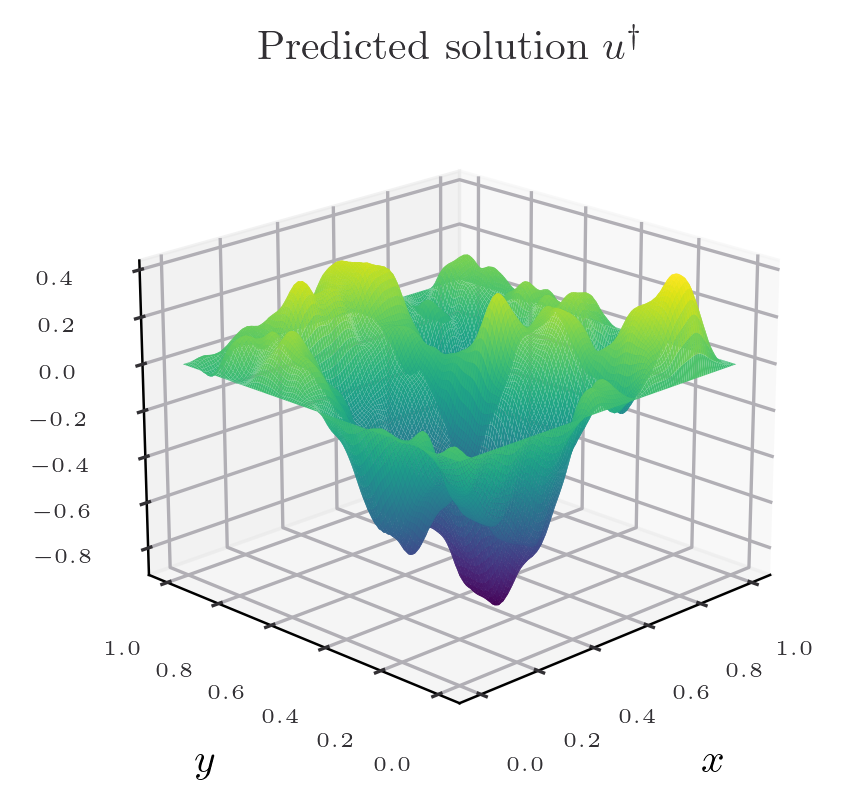

In [36]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

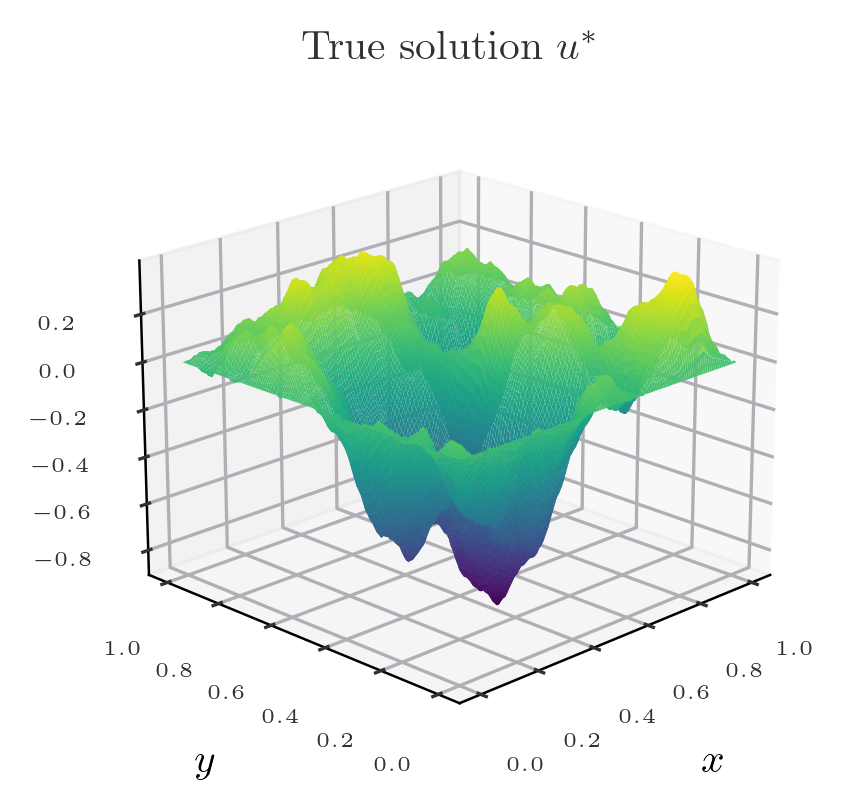

In [37]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [38]:
norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred_grid - u_eval)**2, x_eval), y_eval))
norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u_eval**2, x_eval), y_eval))
print(norm_diff, norm_diff/norm_u)

0.017269157766830183 0.06442647976504226


In [ ]:
# K_interior = L_b_y_tensor(x_finest, y_finest, y, y, length_scale, nu).reshape(n_coef*n_coef, n_points, n_points)
# K_interior = vmap_dst_2d(K_interior)
# K_interior = K_interior.reshape(-1, (n_points)*(n_points))
# K_eval_bc = vmap_kernel(interior_finest, boundary_points, length_scale)
# K_eval = jnp.hstack([K_eval_bc, K_interior])
# print(K_eval.shape, theta.shape)
# pred_finest = jnp.dot(K_eval, alpha)
# pred_grid_finest = jnp.reshape(pred, (n_eval, n_eval))

In [ ]:
# pred_trans = dst_2d(pred_grid_finest)

In [ ]:
# jnp.linalg.norm(pred_trans - coef_u), jnp.linalg.norm(pred_trans - u_trans), jnp.linalg.norm(pred_trans - coef_u)/jnp.linalg.norm(coef_u)

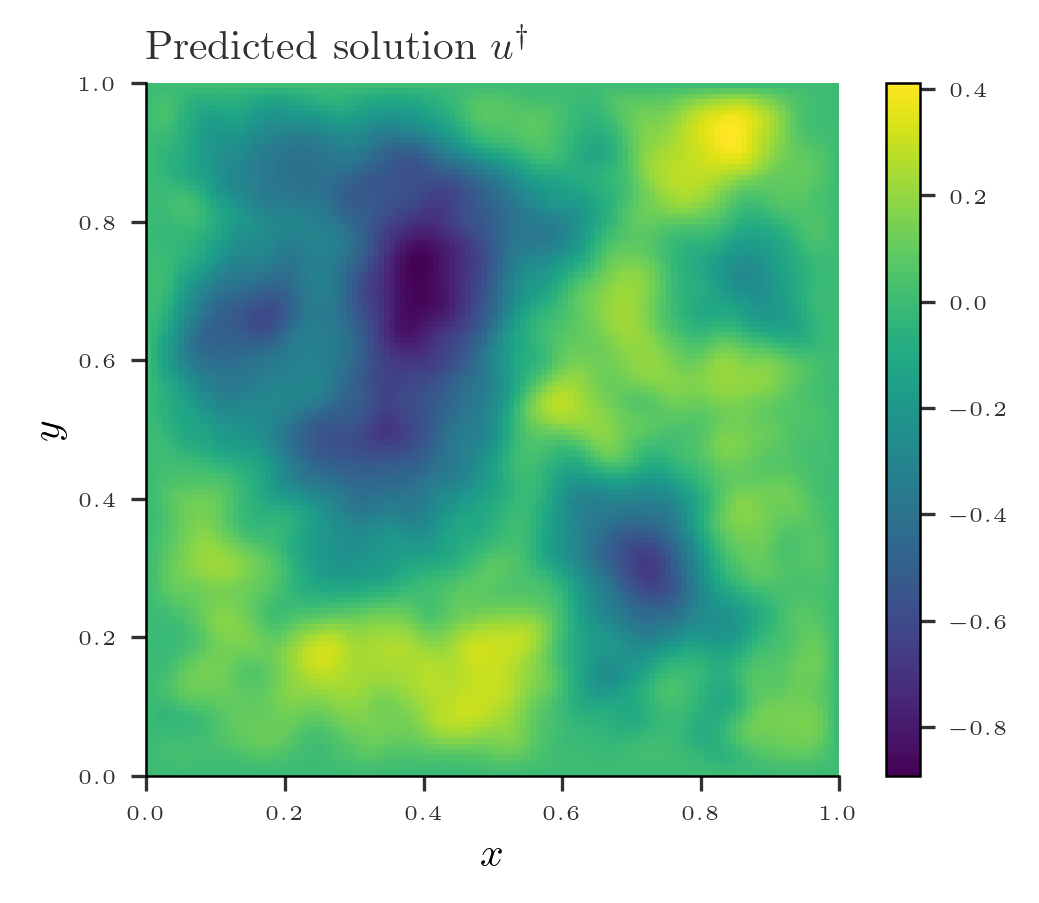

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

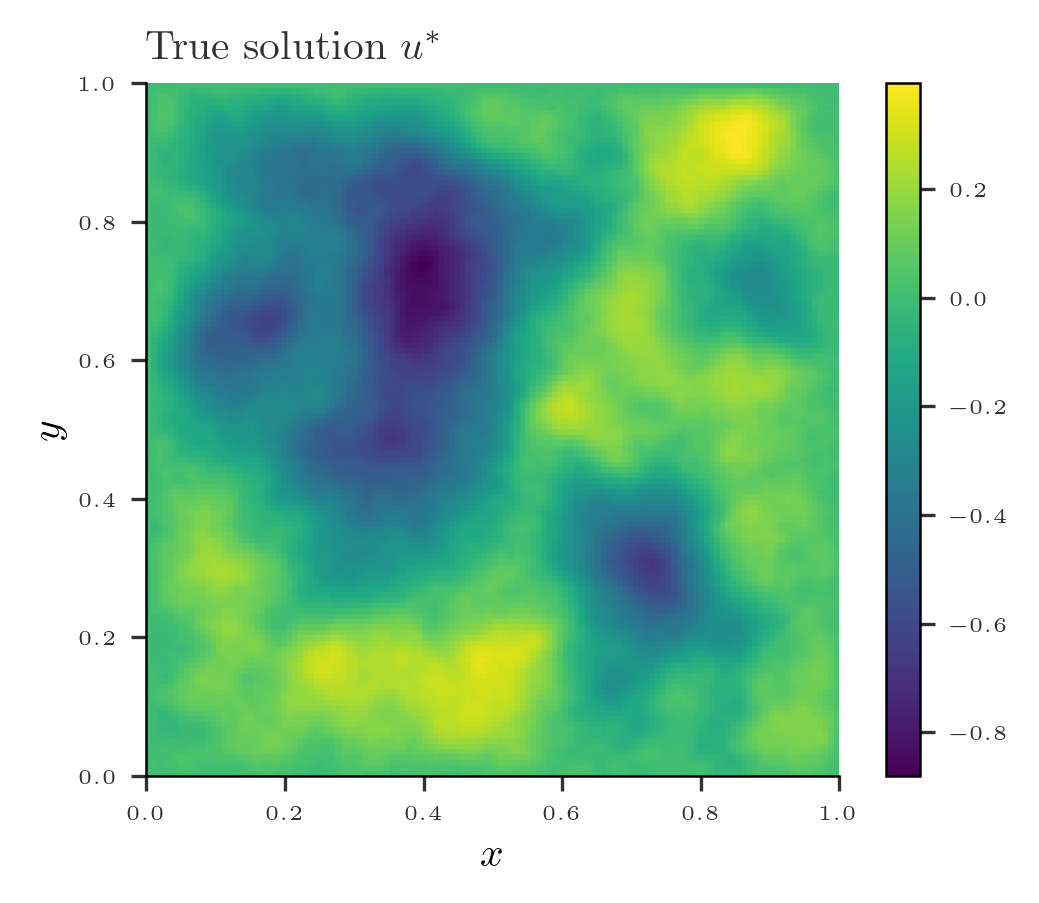

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

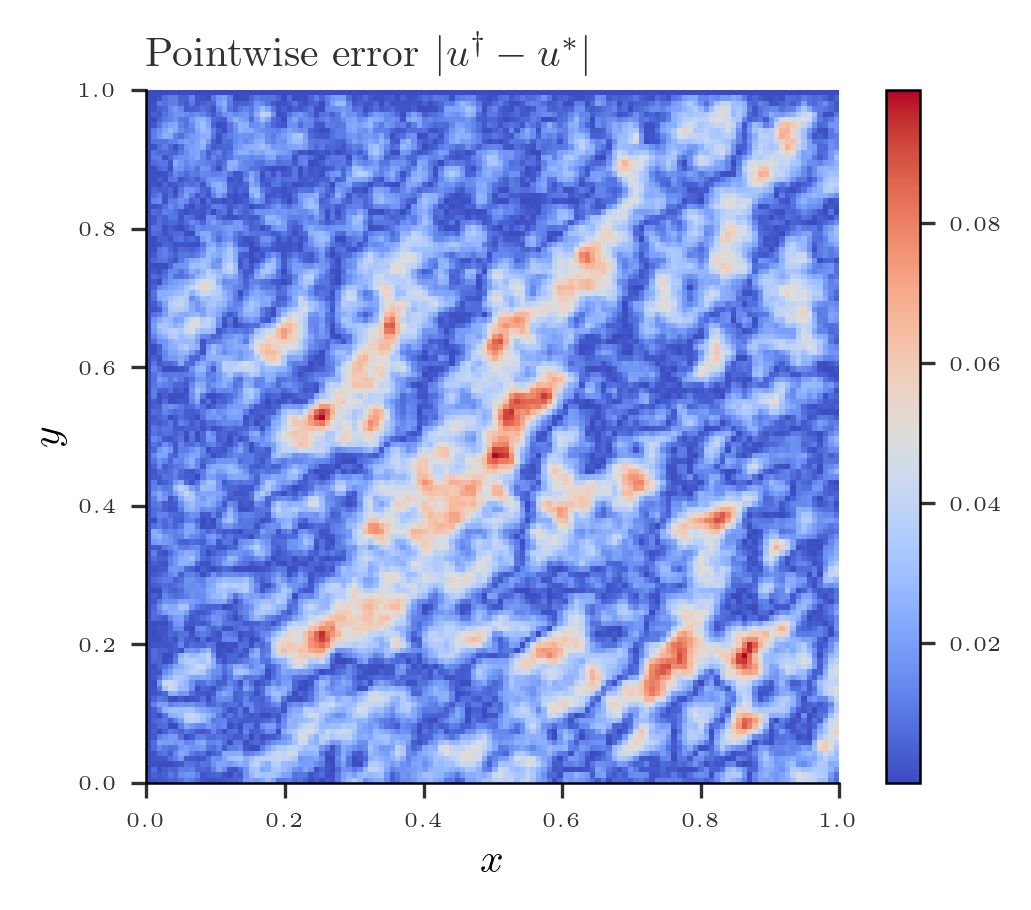

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

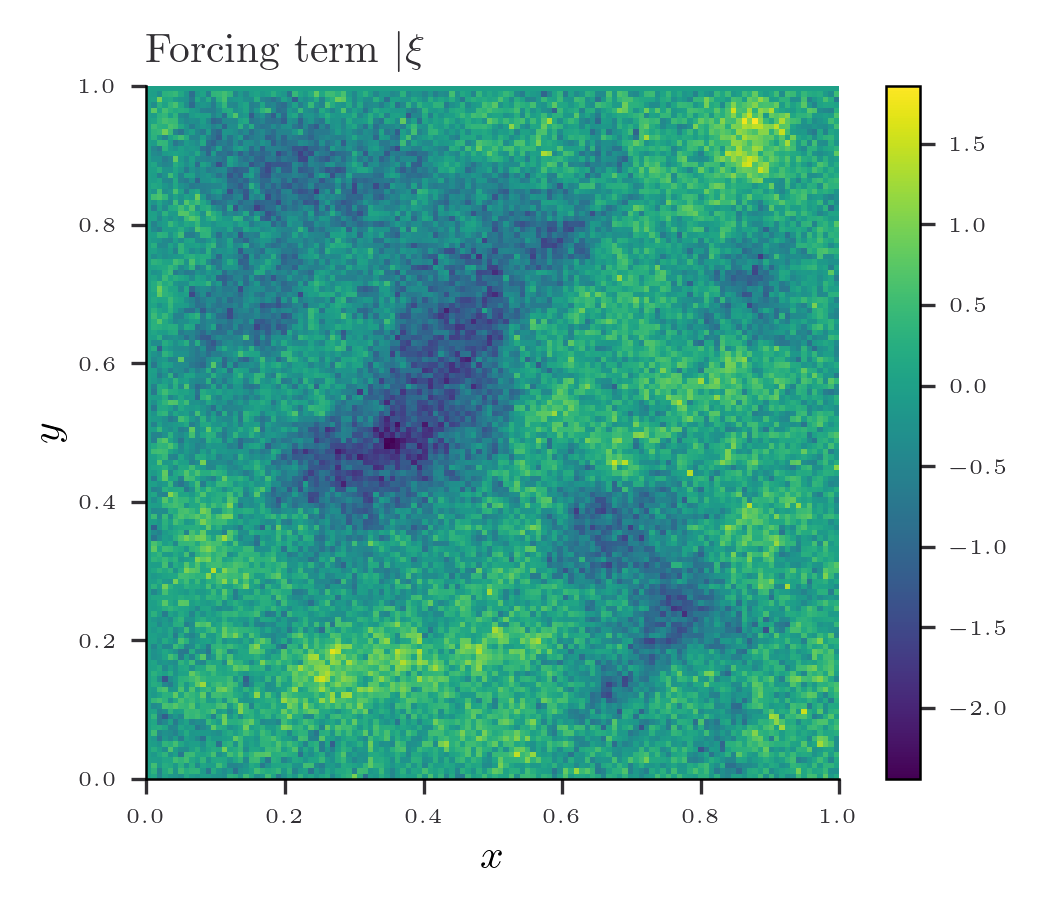

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(f_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Forcing term $|\xi$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Semilinear example


With the Gauss-Newton iteration, we need to solve 

\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n)  - f, \boldsymbol{\psi}]^\intercal \Theta^{-1} [\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

The case we wish to address is 

\begin{align}
&\mathcal{P}(u) = Lu + \tau(u)\\
&\mathcal{P}'(u) = Lu + \tau'(u)
\end{align}

In which case the above problem is 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Denote $r_n = f -\tau(u_n) + \tau'(u_n)u_n$. Then
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - r_n, \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v -r_n, \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Acutally we will have 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,\Big([Lv + \tau'(u_n)v, \boldsymbol{\psi}] - \big([f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi] \big)\Big)^\intercal \Theta^{-1}\Big([Lv + \tau'(u_n)v, \boldsymbol{\psi}] - \big([f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi] \big)\Big) + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}


At each iteration, we need to 

1. Compute $r_n : = [f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi]$
2. Build the new operator/kernel matrix using $\tau'(u_n)$.
3. Solve the system.

We will consider the problem 

\begin{aligned}
 -\nu \Delta u + c \sin(\beta 2\pi u) &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

with a manufactured solution 


\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}


In [184]:
key = random.PRNGKey(558)

n_coef = 2**7
print("Number of coefficients: ", n_coef)

nu = 1e-3
b = 0.0
c = 1.0

x_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
y_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
X, Y = jnp.meshgrid(x_finest, y_finest)
# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x_finest, y_finest, indexing='ij')
interior_finest = jnp.stack((A, B), axis=-1).reshape(-1, 2)



frequencies = jnp.arange(0, n_coef)

delta = .1
alpha = 1.0
random_draw =  random.normal(key, shape= (n_coef,n_coef))
decay = (jnp.arange(0,n_coef)[None]**2 + jnp.arange(0,n_coef)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_u= coef_u.at[:,0].set(0)
coef_u= coef_u.at[0,:].set(0)


coef_laplacian =coef_u*((nu*jnp.pi**2*decay) + b)


Number of coefficients:  128


In [185]:
u_values = evaluate_basis_sine_2d(x_finest,y_finest, coef_u)
beta = 1/2
f_values =  evaluate_basis_sine_2d(x_finest,y_finest, coef_laplacian) + c*jnp.sin(beta*2*jnp.pi*u_values)

#f_values = c*jnp.sin(beta*2*jnp.pi*u_values)

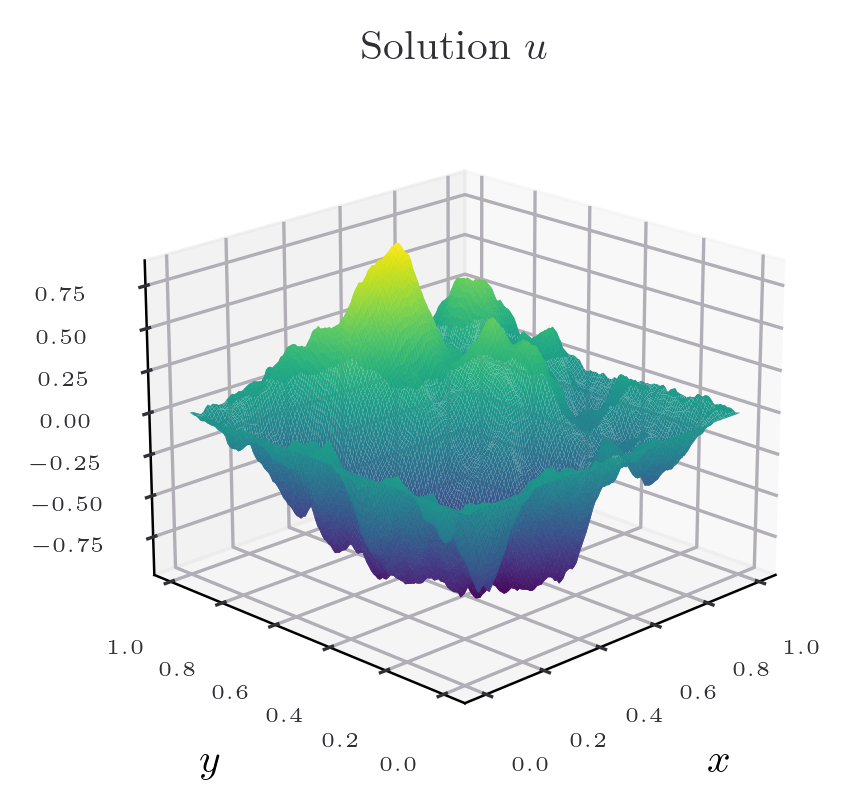

In [186]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

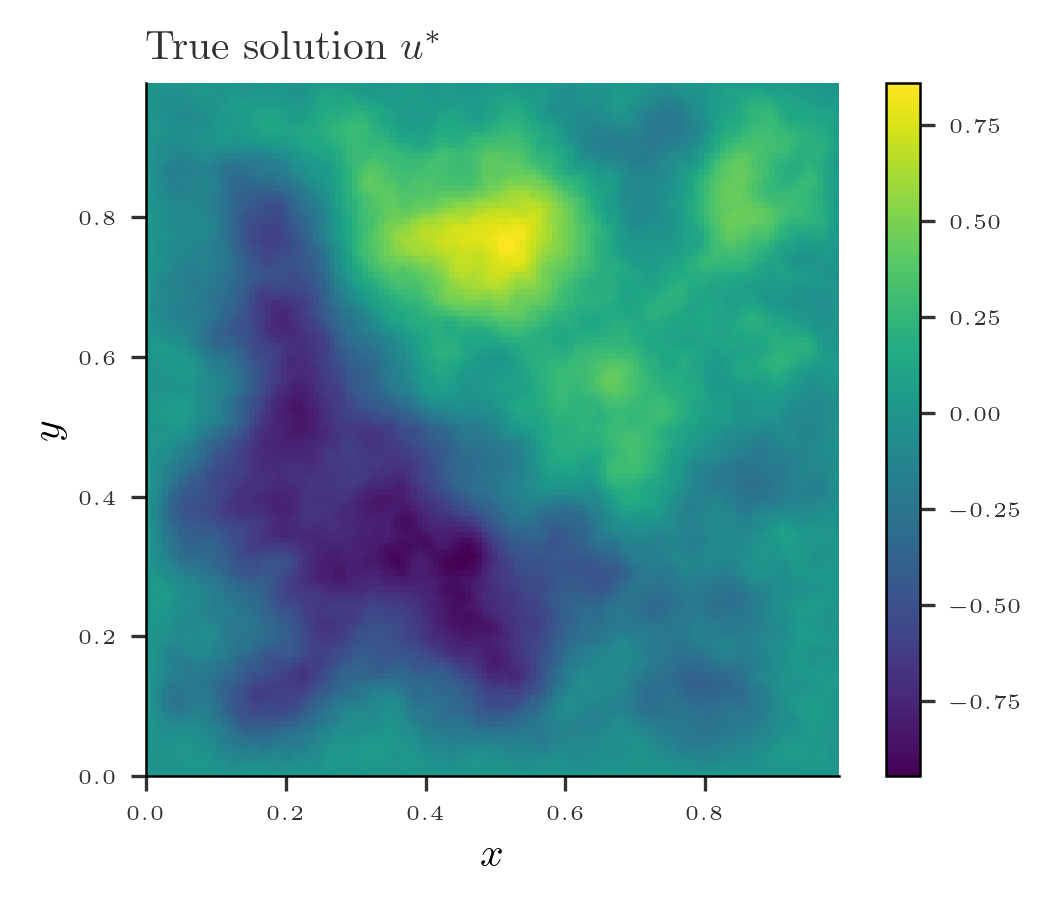

In [187]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

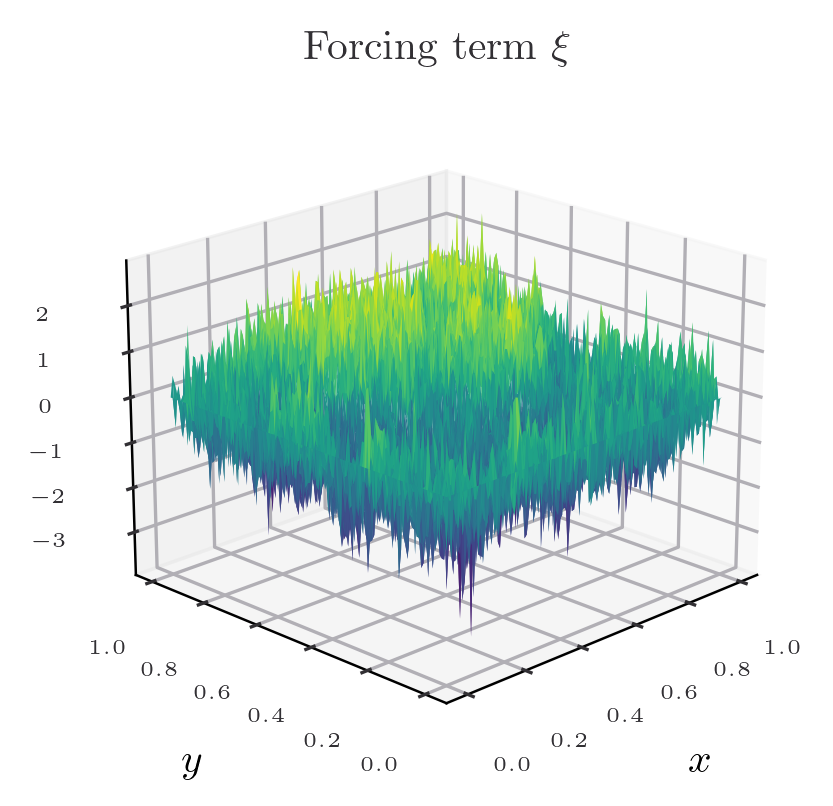

In [188]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

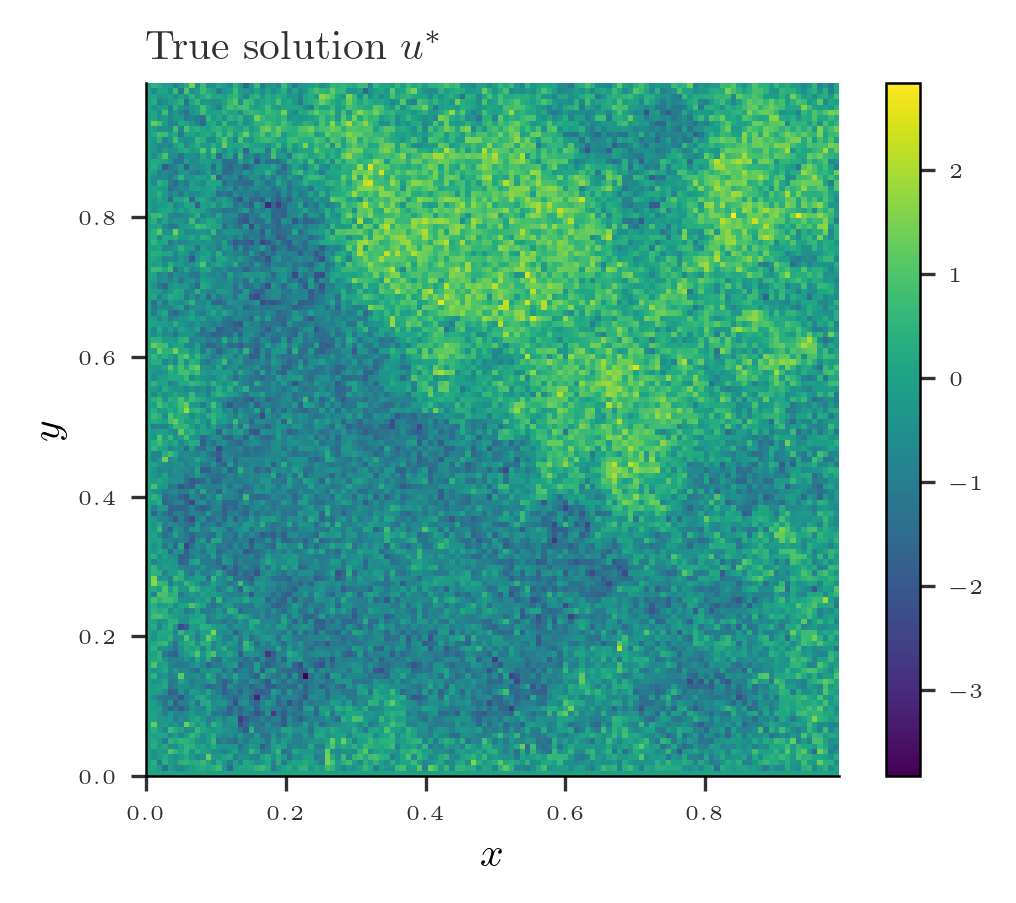

In [189]:
fig = plt.figure(figsize=(width, height))

plt.imshow(f_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

In [190]:
u_trans = dst_2d(u_values)
f_trans = dst_2d(f_values)
print(jnp.mean(jnp.abs(u_trans- coef_u)))

5.1819899317343874e-05


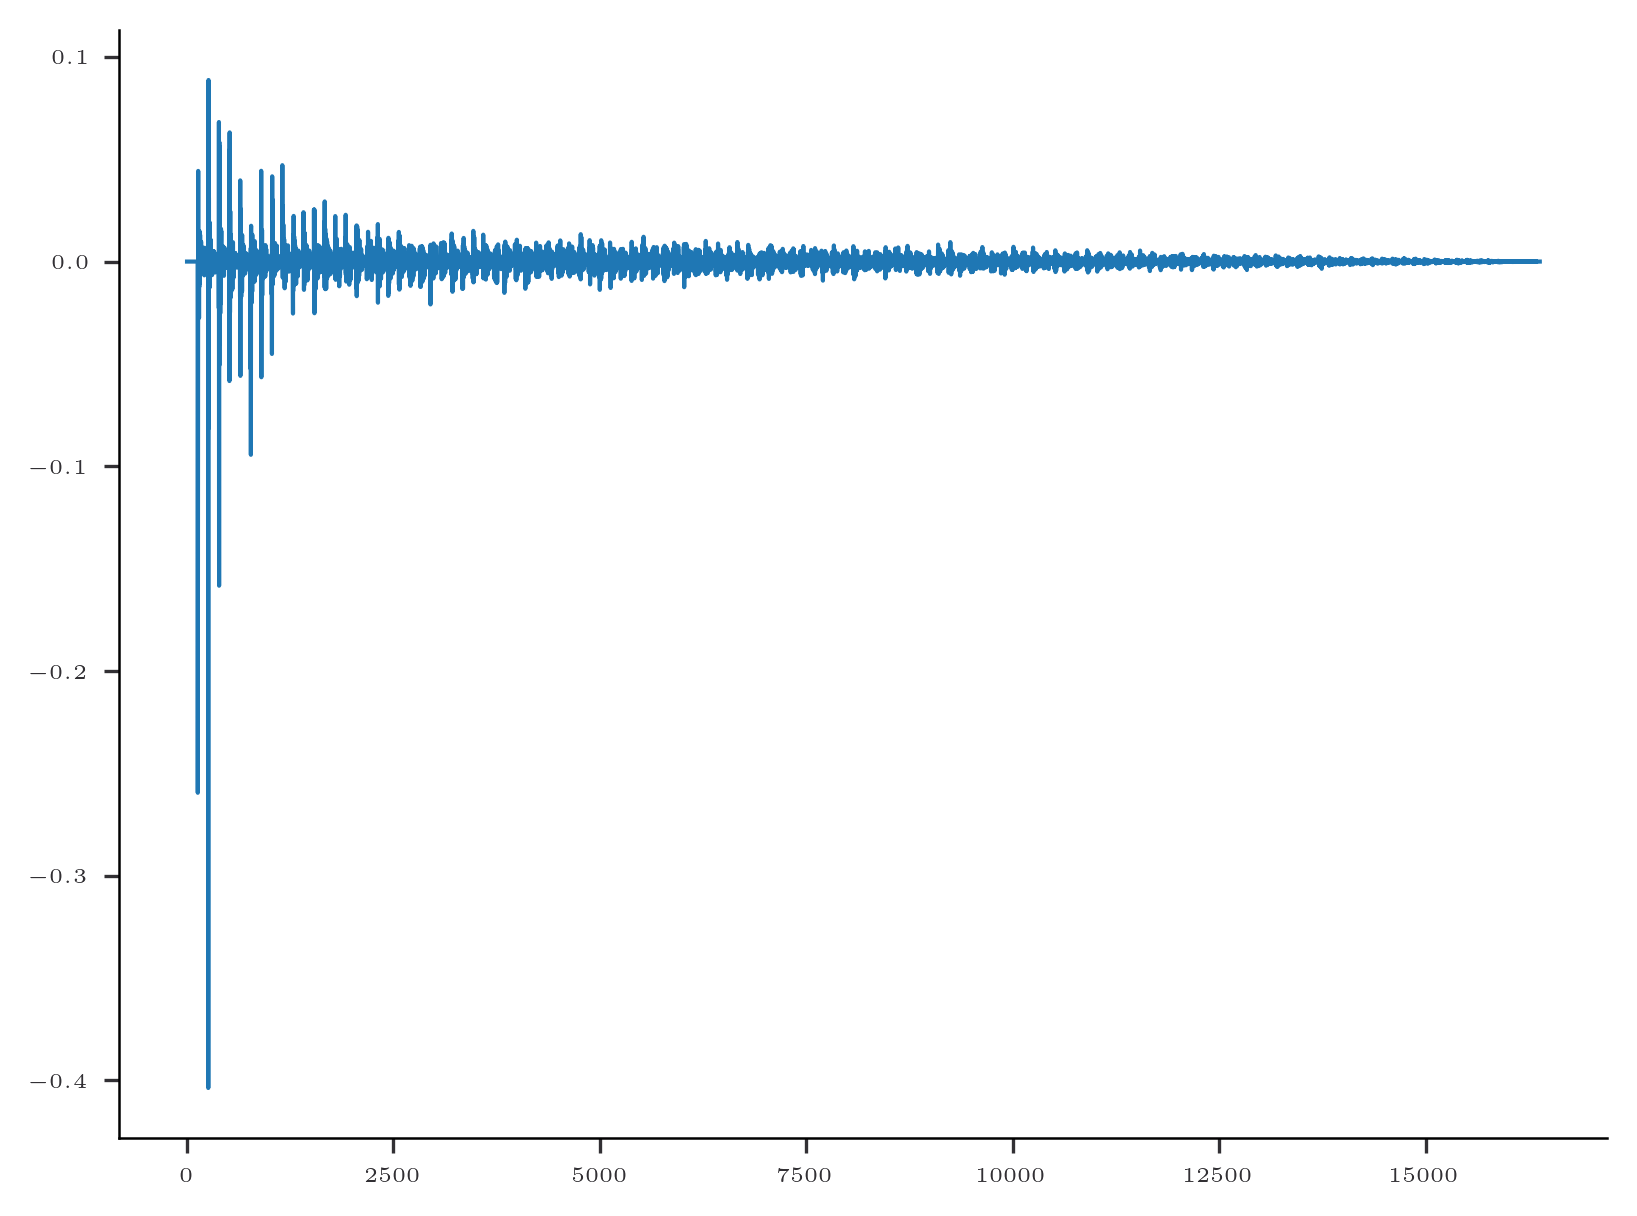

In [191]:
plt.plot(f_trans.reshape(-1), label = "f")